In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
import sys
from hod.emulator.s3_pred_radius import PredDataVector

In [2]:
# plot the lensing for fiducial cosmology, using emulator
# compare with the original
# then vary sigma8
## First, verify that the emulator can recover the fiducial model
# read the fiducial parameters
cosmo_id = 0
hod_id = 0
from hod.utils.get_para_abacus_summit import get_cosmo_para, get_hod_para
cosmo_para_dict = get_cosmo_para(cosmo_id)
hod_para_dict = get_hod_para(hod_id)
para = cosmo_para_dict | hod_para_dict
# copied from s1_collect_data.py
cosmo_para_fid = [para['sigma8'], para['OmegaM'], para['ns'], para['OmegaB'], para['w0'], para['wa'], para['Nur'], para['alpha_s']]
hod_para_fid = [para['alpha'], para['lgM1'], para['lgkappa'], para['lgMcut'], para['sigmalogM']]
para_fid = np.append(cosmo_para_fid, hod_para_fid)
X_test = np.atleast_2d(para_fid) # just one set of parameters
print(X_test)

## First check emulator predction vs. input (sanity check)
# Emulator prediction
emu_name = 'all'
binning = 'lam'
iz = 0
zid = 3
zmin = 0.2
zmax = 0.35
loc = '/projects/hywu/cluster_sims/cluster_finding/data/'
train_loc = loc + f'emulator_train/{emu_name}/z0p{zid}00/{binning}/'
survey = 'abacus_summit' #'desy1'
data_vector=['counts', 'lensing']

#############
pdv = PredDataVector(emu_name, binning, iz, survey, data_vector)
DS_pred = pdv.pred_lensing(X_test)
abun_pred = pdv.pred_abundance(X_test)

#### compare with the orignal (need to interpolate the radius)
loc = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_data/'
loc += 'base_c000_ph000/z0p300/model_hod000000/obs_q180_bg_miscen_desy1/'

rp_list = np.logspace(np.log10(0.03), np.log10(30), 15+1)
rpmin_list = rp_list[:-1]
rpmax_list = rp_list[1:]
rpmid_list = np.sqrt(rpmin_list*rpmax_list)
rp_master_rad = rpmid_list[rpmid_list>0.2]

from scipy.interpolate import interp1d

DS_test = []
for ibin in range(4):
    rp, DS = np.loadtxt(loc + f'DS_phys_noh_{binning}_bin_{ibin}.dat', unpack=True)
    lnDS_interp = interp1d(np.log(rp), np.log(DS))
    DS_interp = np.exp(lnDS_interp(np.log(rp_master_rad)))
    DS_test.extend(DS_interp)

abun_test = np.loadtxt(loc+'abundance.dat')[:,2]
print((abun_pred-abun_test)/abun_pred)
print((DS_pred-DS_test)/DS_pred)
# Okay, test passed!!! 

[[ 0.807952    0.31519187  0.9649      0.04930169 -1.          0.
   2.0328      0.          1.         12.9         0.         11.7
   0.1       ]]
[-0.0039355   0.00037643  0.01318296 -0.018154  ]
[ 0.00333854  0.00352002  0.00421642  0.00718167  0.00747372  0.00050435
 -0.00371426 -0.00429837 -0.00148724  0.00131222  0.00333679  0.00089389
  0.00730352  0.00492717  0.00841001  0.01245638  0.00782662  0.00587293
 -0.00056535 -0.00610935 -0.00417086 -0.00213355  0.00019764  0.00782426
  0.00759067  0.00748464  0.0148425   0.00723894 -0.00146745 -0.00424354
 -0.00271941 -0.00674221  0.0082331   0.0117647  -0.00108488  0.01077313
  0.00557294  0.01536605  0.01222554  0.00866486 -0.0046729   0.00125986
  0.00084597  0.01080554]


In [3]:
key_list = ['sigma8', 'OmegaM', 'ns', 'OmegaB', 'w0', 'wa', 'Nur', 'alpha_s']
key_list2 = [r'$\sigma_8$', r'$\Omega_{\rm m}$', 
r'$n_{\rm s}$', r'$\Omega_{\rm b}$', r'$w_0$', r'$w_{\rm a}$', 
r'$N_{\rm ur}$', r'$\alpha_{\rm s}$']
npara = len(key_list)
nrp = 11

# Now, vary one parameter at a time!
# lensing only

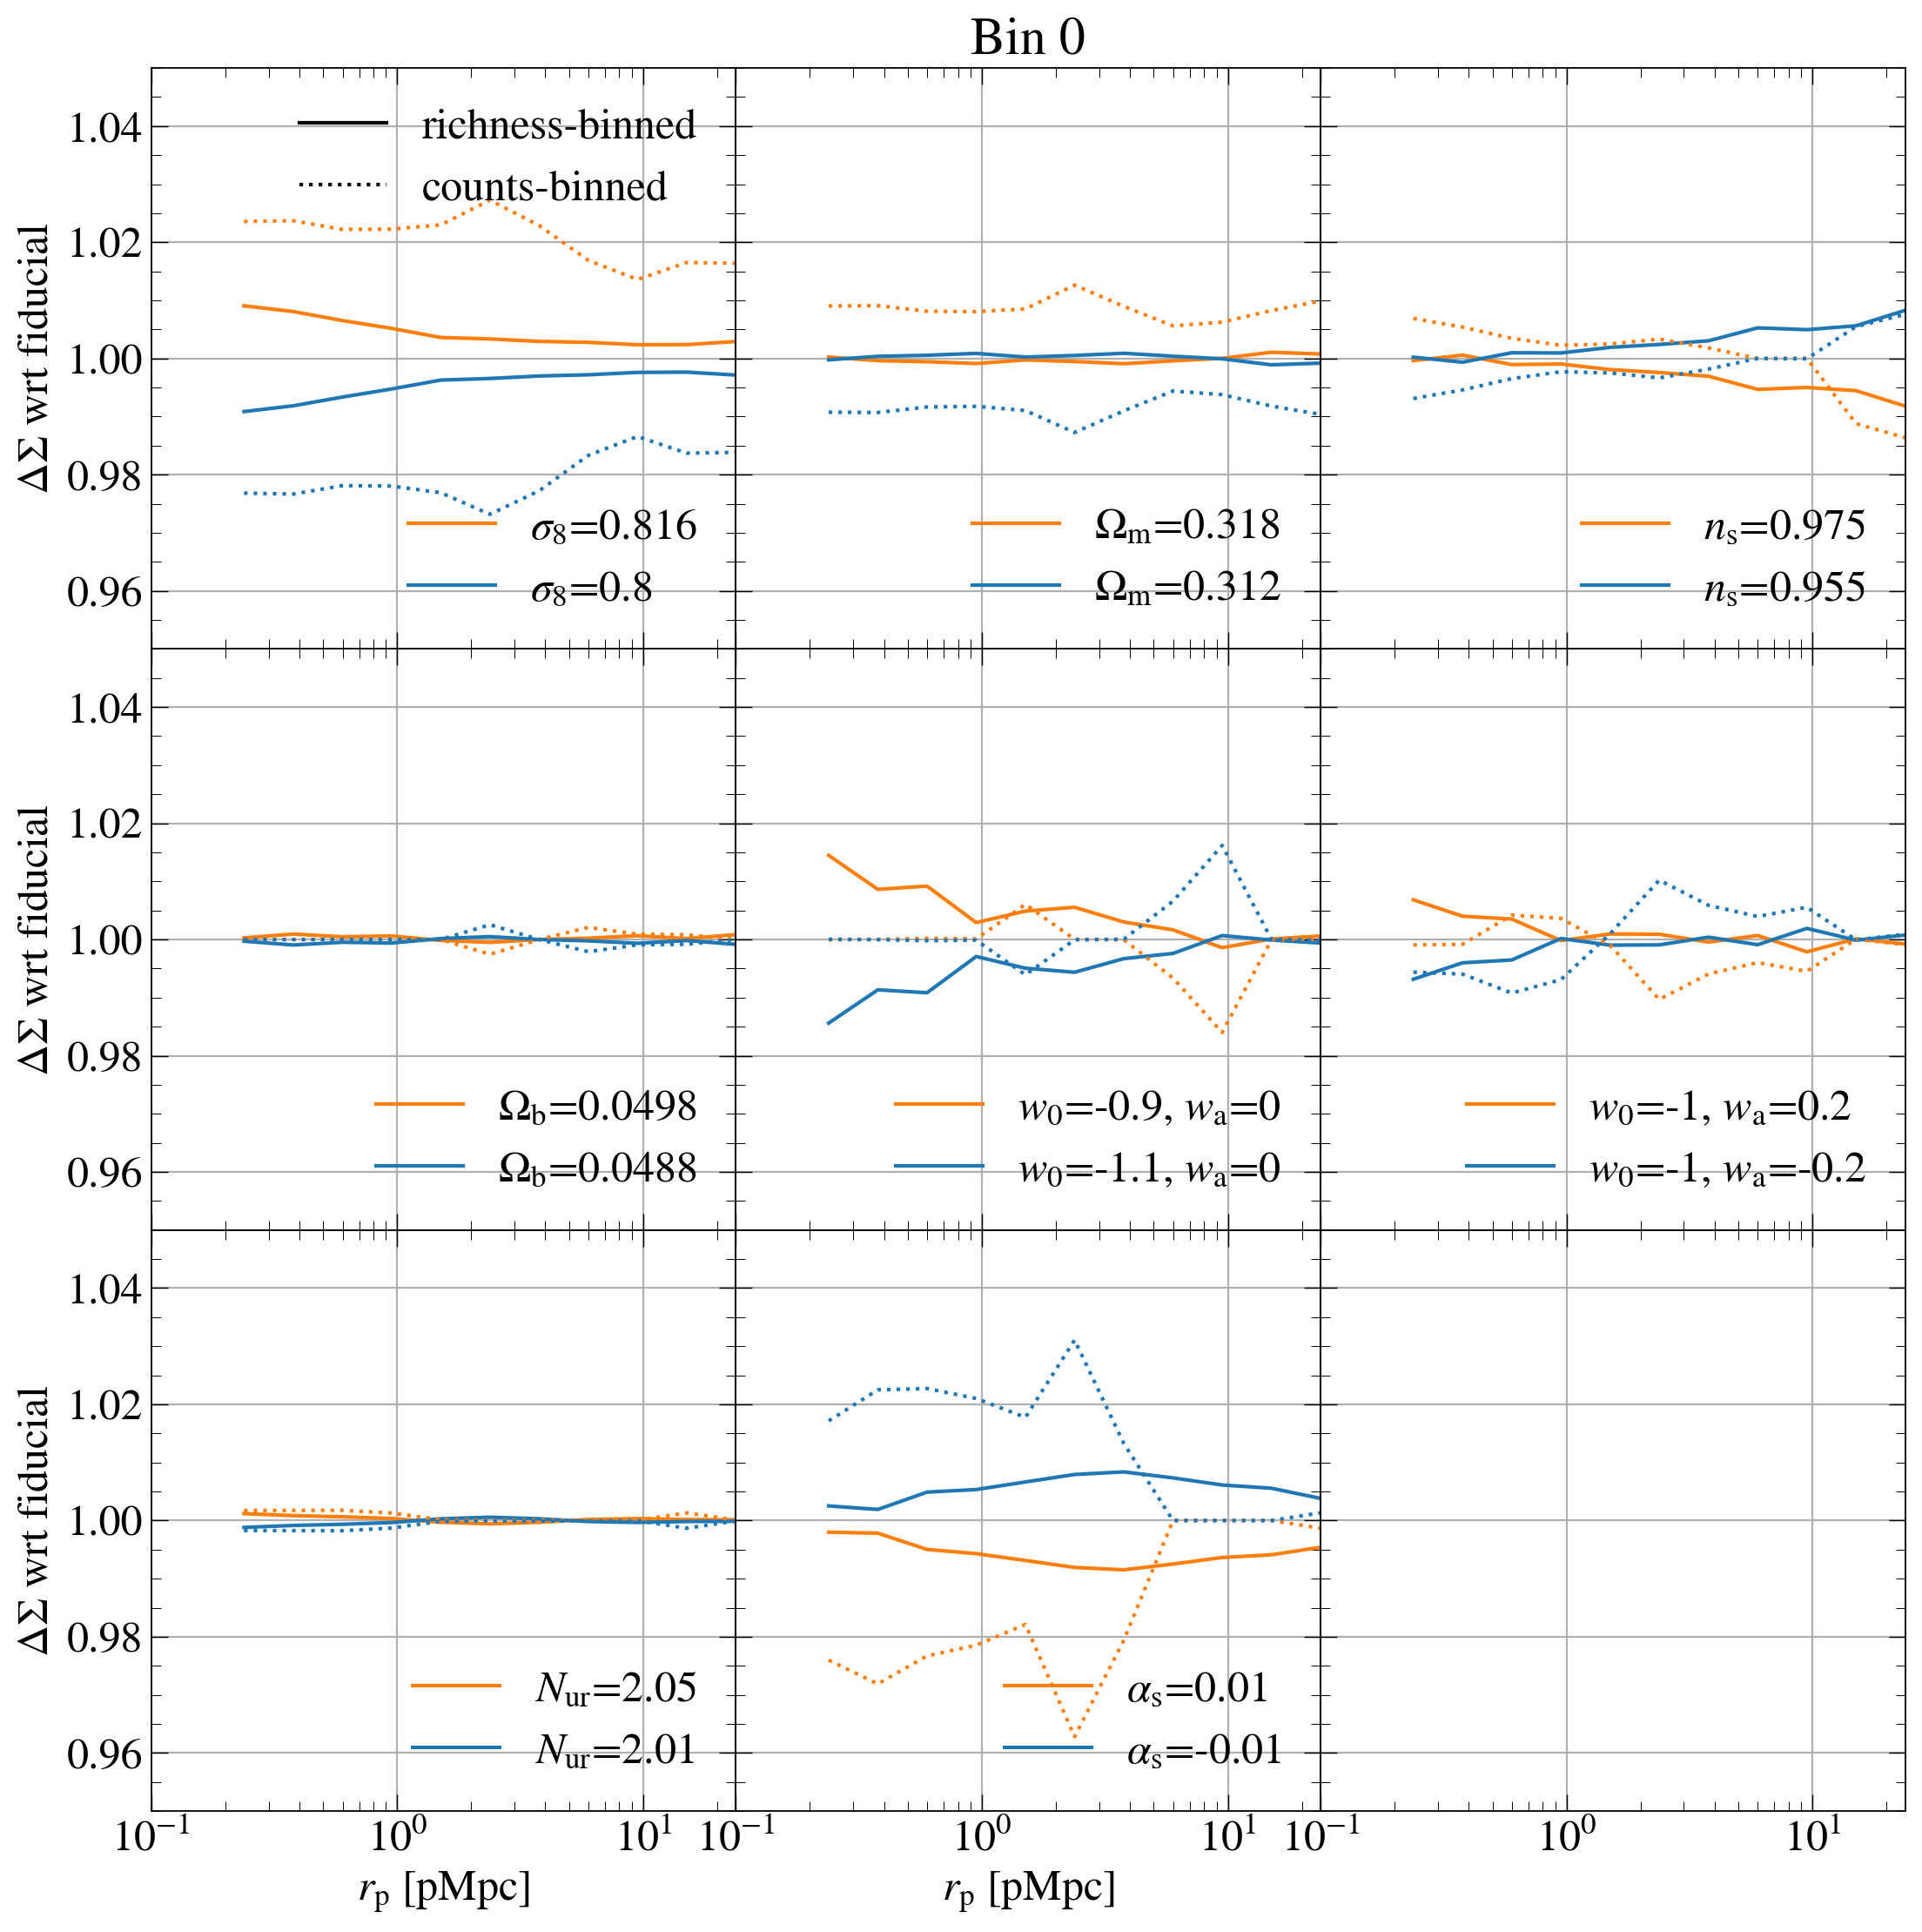

In [4]:
for ibin in [0]: #range(4):        
    fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 13), gridspec_kw = {'wspace':0, 'hspace':0})
    
    plt.subplot(3,3,1) # add legend only to the first panel
    x = np.linspace(0.1,1)
    line1, = plt.plot(x, -100+0*x, c='k', ls='-', label='richness-binned')
    line2, = plt.plot(x, -100+0*x, c='k', ls=':', label='counts-binned')
    legend1 = plt.legend(handles=[line1, line2], loc=1, frameon=False)
    plt.gca().add_artist(legend1)
    #plt.legend(loc=4,frameon=False)
    
    plt.subplot(3,3,2) # add bin id to the second panel
    plt.title(f'Bin {ibin}')
    
    for binning in ['lam', 'abun']:
        pdv = PredDataVector(emu_name, binning, iz, survey, data_vector=['lensing'])
        DS_fid = pdv.pred_lensing(np.atleast_2d(para_fid))
            
        for ipara in range(npara):
            plt.subplot(3,3,ipara+1)
            legend_handles = []
            for p_or_m in [1, -1]:
                pm = np.zeros(npara)
                pm[ipara] = p_or_m
                para_vary = para_fid * 1.
                # if para_fid[ipara] != 0:
                #     para_vary[ipara] = para_fid[ipara]*(1+0.01*p_or_m)
                # else:
                #     para_vary[ipara] = para_fid[ipara] + 0.01*p_or_m
                if para_fid[ipara] != 0:
                    para_vary[ipara] = para_fid[ipara]*(1+0.01*p_or_m)
                else:
                    para_vary[ipara] = para_fid[ipara] + 0.01*p_or_m
        
                if key_list[ipara] in ['w0']: # 10% for wa
                    para_vary[ipara] = para_fid[ipara] + 0.1*p_or_m
                    
                if key_list[ipara] in ['wa']: # 20% for wa
                    para_vary[ipara] = para_fid[ipara] + 0.2*p_or_m

                
                X_test = np.atleast_2d(para_vary)
                DS_pred = pdv.pred_lensing(X_test)

                if p_or_m == 1:
                    c = 'C1' # orange
                if p_or_m == -1:
                    c = 'C0' # blue
                    
                if binning == 'lam':
                    ls = '-'
                if binning == 'abun':
                    ls = ':'

                key = key_list[ipara]
                key2 = key_list2[ipara]

                # can't do satellite fraction yet...
                label = f'{key_list2[ipara]}={para_vary[ipara]:.3g}'

                if key_list[ipara] in ['w0', 'wa']:
                    label = f'{key_list2[4]}={para_vary[4]:.3g}, {key_list2[5]}={para_vary[5]:.3g}'
                 
                line3, = plt.plot(rp_master_rad, DS_pred[ibin*nrp:(ibin+1)*nrp]/DS_fid[ibin*nrp:(ibin+1)*nrp], c=c, ls=ls,\
                         label=label)
                legend_handles.append(line3)
                plt.ylim(0.95, 1.05)
                plt.xscale('log')
                
                if binning == 'lam':
                    plt.legend(handles=legend_handles, loc=4, frameon=False)
                if ipara > 5:
                    plt.xlabel(r'$r_{\rm p} ~ [{\rm pMpc}]$')
                if ipara % 3 == 0:
                    #plt.ylabel(r'$\rm r_{\rm p} \Delta\Sigma ~ [{\rm pMpc M_\odot ppc^{-2}}]$')
                    plt.ylabel(r'$\Delta\Sigma$ wrt fiducial')
    if ibin==0:
        plt.savefig(f'../../plots/for_paper/sensitivities_cosmo_lensing_bin{ibin}.pdf')

# Counts

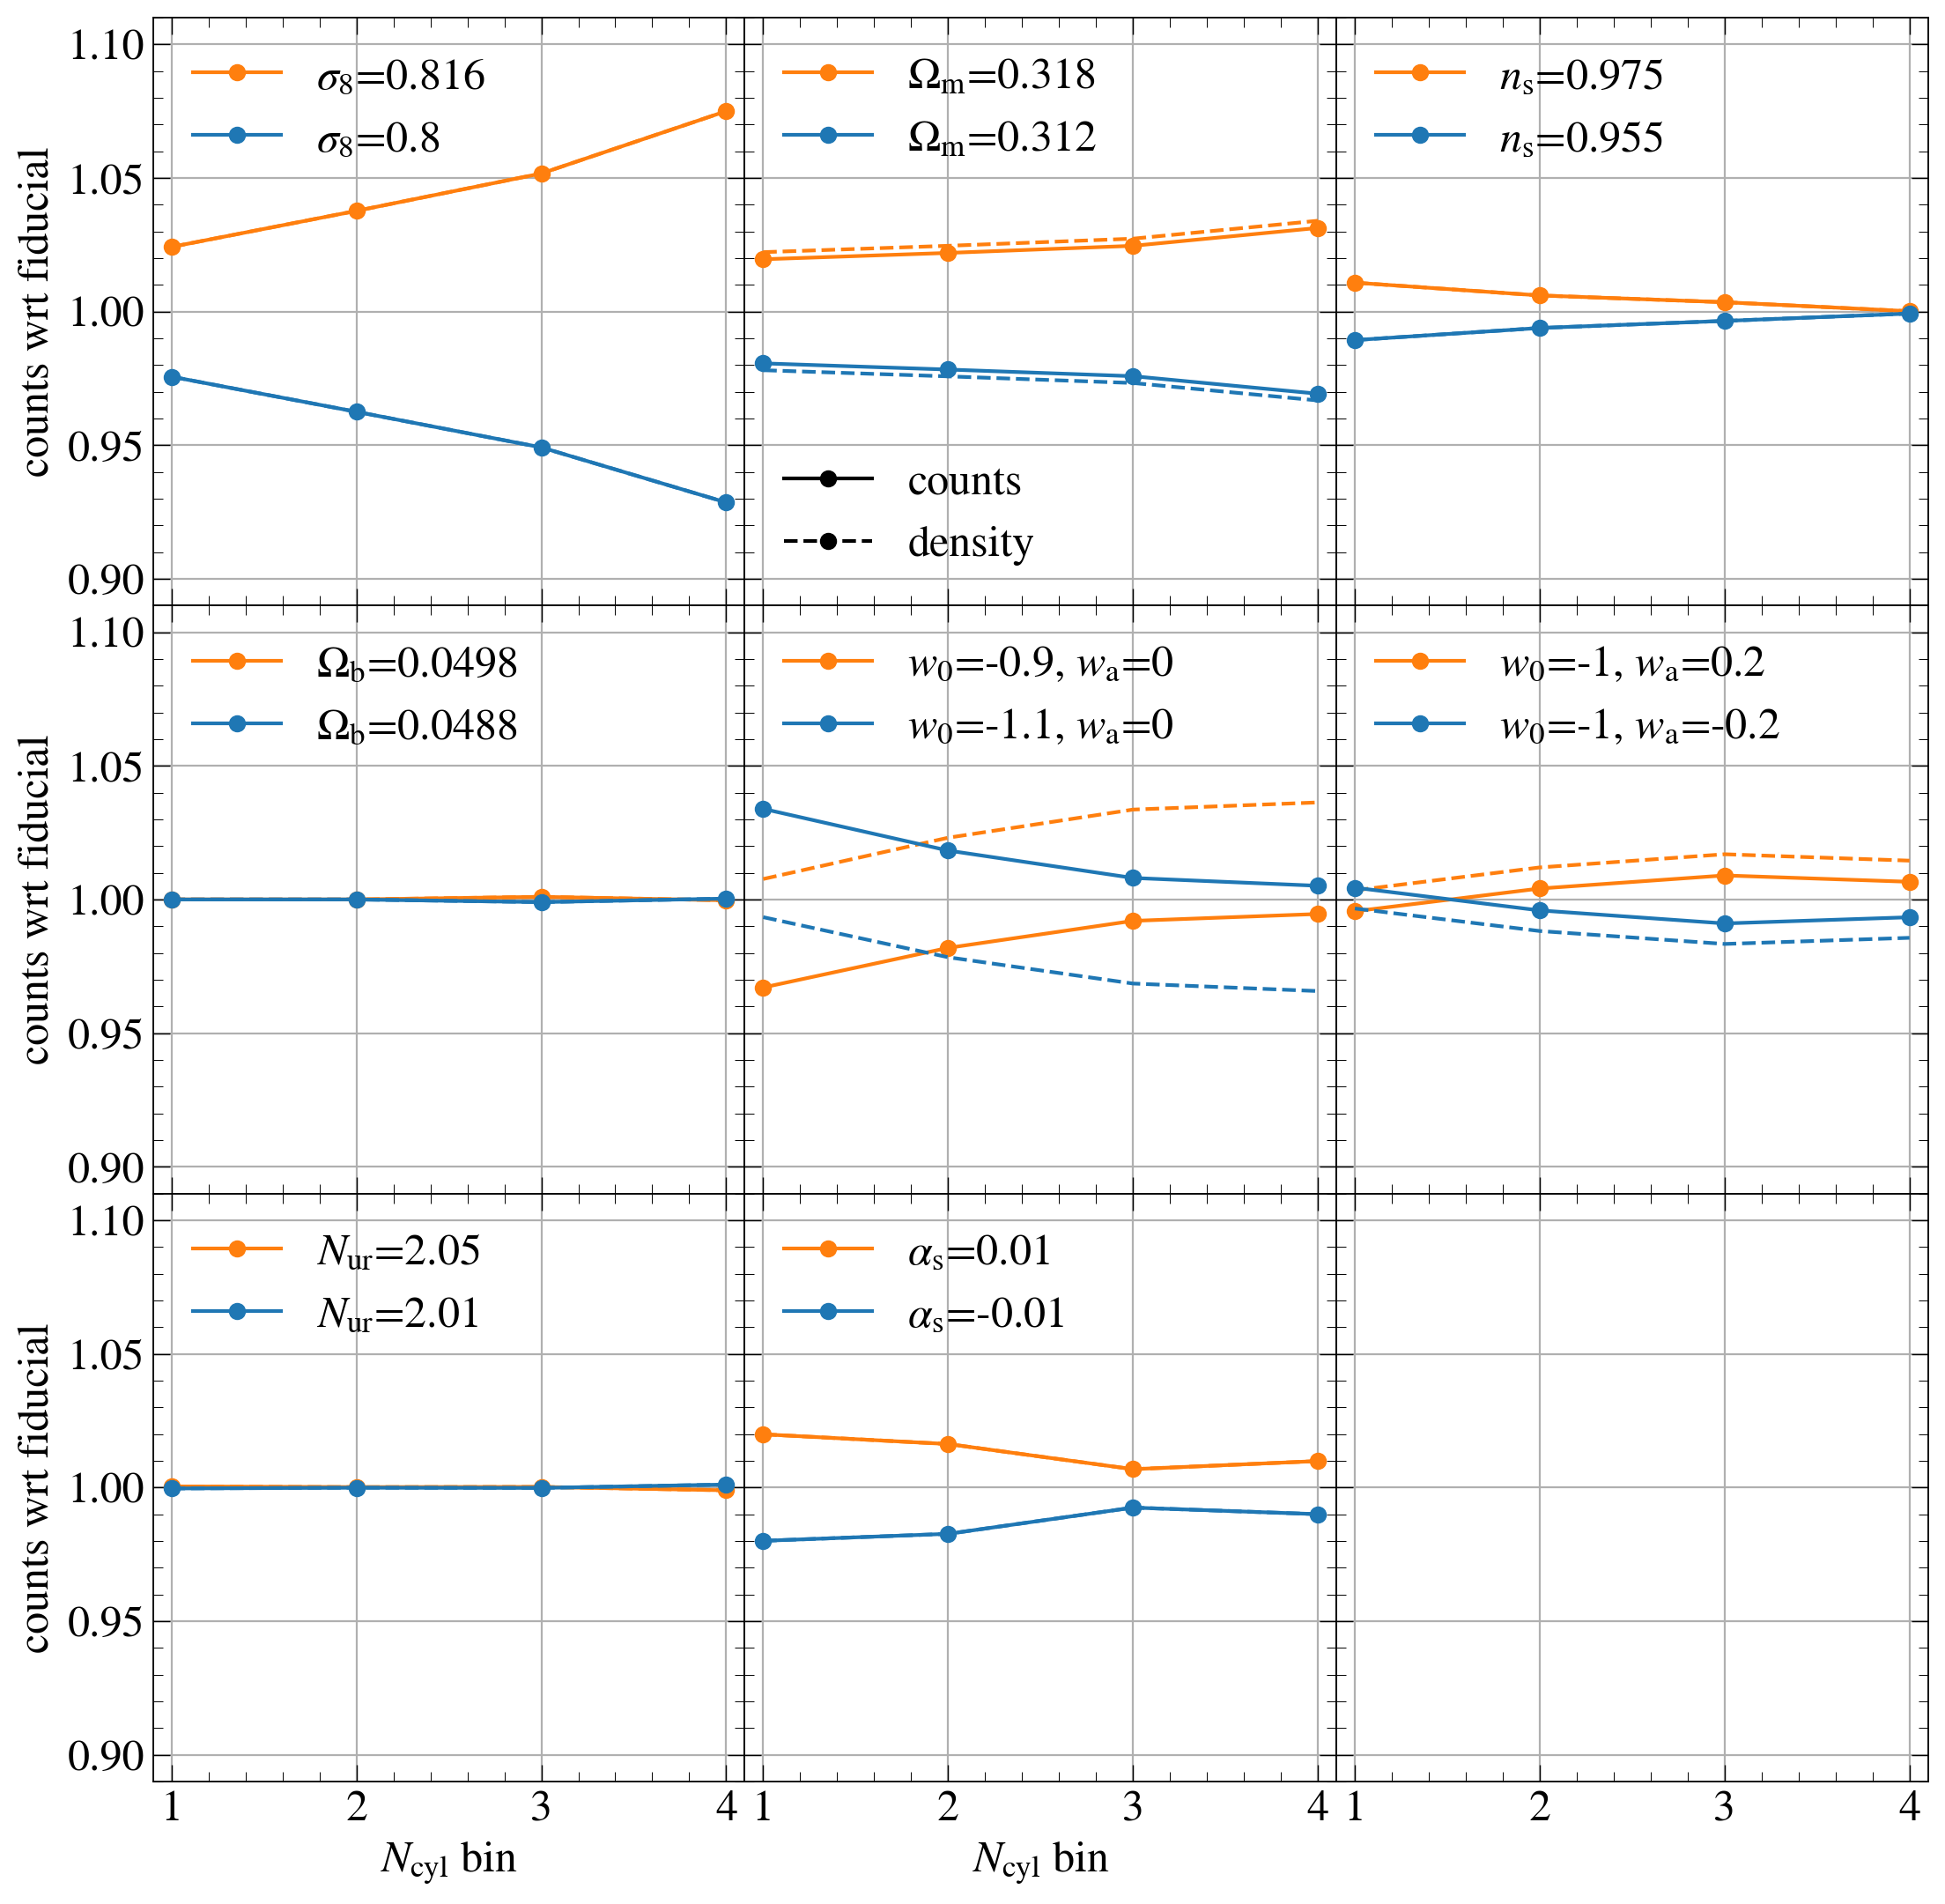

In [5]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(13, 13), gridspec_kw = {'wspace':0, 'hspace':0})

binning = 'lam'

#for binning in ['lam']:
pdv = PredDataVector(emu_name, binning, iz, survey, data_vector=['counts'])
abun_fid = pdv.pred_abundance(np.atleast_2d(para_fid))
from astropy.cosmology import w0waCDM
Om0 = para_fid[1]
Ode0 = 1-Om0
w0 = para_fid[4]
wa = para_fid[5]
cosmo = w0waCDM(H0=100, Om0=Om0, Ode0=Ode0, w0=w0, wa=wa)
volume_fid = cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)
den_fid = abun_fid / volume_fid


plt.subplot(3,3,2) # add legend only to the Om panel
x = np.linspace(0.1,1)
line1, = plt.plot(x, -100+0*x, 'o-', c='k', label='counts')
line2, = plt.plot(x, -100+0*x, 'o--', c='k', label='density')
legend1 = plt.legend(handles=[line1, line2], loc=3, frameon=False)
plt.gca().add_artist(legend1)

for ipara in range(npara):
    plt.subplot(3,3,ipara+1)
    legend_handles = []
    for p_or_m in [1, -1]:
        pm = np.zeros(npara)
        pm[ipara] = p_or_m
        para_vary = para_fid * 1.
        if para_fid[ipara] != 0:
            para_vary[ipara] = para_fid[ipara]*(1+0.01*p_or_m)
        else:
            para_vary[ipara] = para_fid[ipara] + 0.01*p_or_m

        if key_list[ipara] in ['w0']: # 10% for wa
            para_vary[ipara] = para_fid[ipara] + 0.1*p_or_m
            
        if key_list[ipara] in ['wa']: # 20% for wa
            para_vary[ipara] = para_fid[ipara] + 0.2*p_or_m


        
        X_test = np.atleast_2d(para_vary)
        abun_pred = pdv.pred_abundance(X_test)

        if p_or_m == 1:
            c = 'C1' # orange
        if p_or_m == -1:
            c = 'C0' # blue

        ##### volume ##### 
        Om0 = para_vary[1]
        Ode0 = 1-Om0
        w0 = para_vary[4]
        wa = para_vary[5]
        cosmo = w0waCDM(H0=100, Om0=Om0, Ode0=Ode0, w0=w0, wa=wa)
        volume = cosmo.comoving_volume(zmax) - cosmo.comoving_volume(zmin)
        den_pred = abun_pred / volume
        
        label = f'{key_list2[ipara]}={para_vary[ipara]:.3g}'
        if key_list[ipara] in ['w0', 'wa']:
            label = f'{key_list2[4]}={para_vary[4]:.3g}, {key_list2[5]}={para_vary[5]:.3g}'

        
        line3, = plt.plot(np.arange(1,5), abun_pred/abun_fid, 'o-', c=c,
                 label=label)
        legend_handles.append(line3)
        plt.plot(np.arange(1,5), den_pred/den_fid, '--', c=c)
        #plt.legend(loc=2, frameon=False)
        plt.legend(handles=legend_handles, loc=2, frameon=False)
    
    if ipara > 5:
        plt.xlabel(r'$N_{\rm cyl}$ bin')
    if ipara % 3 == 0:
        plt.ylabel(r'counts wrt fiducial')
    plt.xlim(0.9, 4.1)
    plt.ylim(0.89, 1.11)

plt.savefig('../../plots/for_paper/sensitivities_cosmo_counts.pdf')